## Stacking Modeling 
In this notebook, we implemented and evaluated a Stacking model (RF and XGBoost as base learners, with Logistic regression as meta learner) to to predict **auto loan default** (bad_flag).

In [31]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from preprocessing import load_data, preprocess_data
from model_evaluation import evaluate_models, tune_hyperparameters, feature_importance, threshold_analysis, cross_val_pr_curve, cross_val_roc_curve
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


## Load & Preprocess Data

In [26]:
train_path = "/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
eval_path = "/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"

df_train, df_eval = load_data(train_path, eval_path)
X_train_processed, y_train, X_eval_processed, y_eval, to_drop_corr, cols_to_drop, preprocessor = preprocess_data(df_train, df_eval)

print("Train shape:", X_train_processed.shape)
print("Eval shape:", X_eval_processed.shape)

Train shape: (21348, 28)
Eval shape: (5336, 28)


/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CV Scores: [0.11657559 0.1106175  0.10508797]
Mean CV Score: 0.1107603549615218


/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:               precision    recall  f1-score   support

           0       0.98      0.71      0.83     20390
           1       0.11      0.76      0.19       958

    accuracy                           0.72     21348
   macro avg       0.55      0.74      0.51     21348
weighted avg       0.95      0.72      0.80     21348



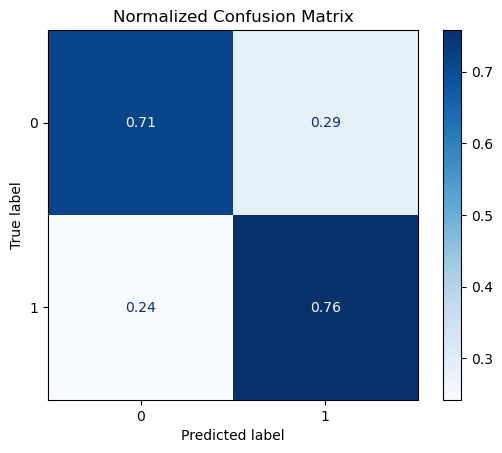

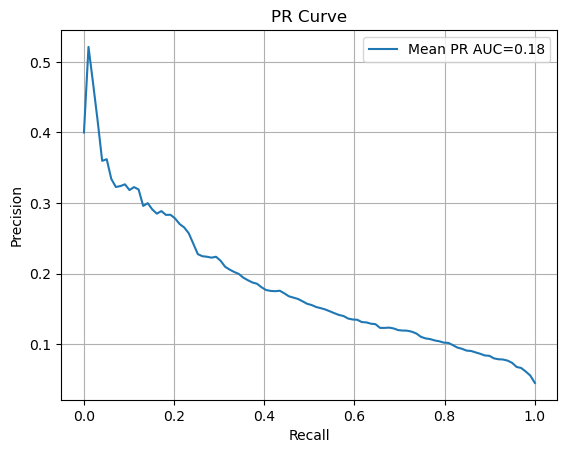

Mean PR AUC: 0.1825


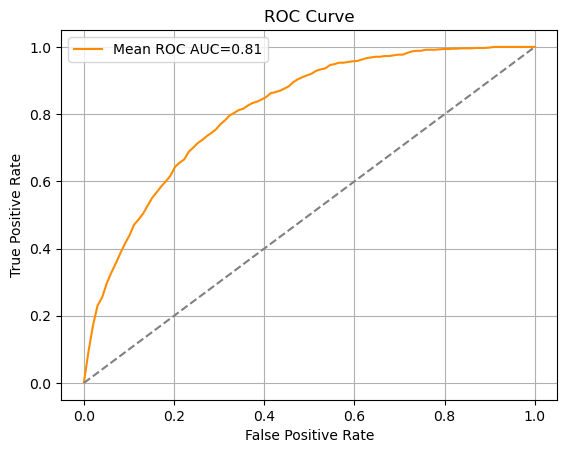

Mean ROC AUC: 0.8116

=== Final Evaluation on Test Set ===
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      5094
           1       0.11      0.75      0.20       242

    accuracy                           0.72      5336
   macro avg       0.55      0.74      0.52      5336
weighted avg       0.94      0.72      0.80      5336



In [27]:
# Define base learners
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)

xgb_clf = xgb.XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=300,
    scale_pos_weight=0.3544383149448345,
    subsample=0.7,
    eval_metric='logloss',
    random_state=42
)

# Meta learner
meta_learner = LogisticRegression(max_iter=5000, class_weight='balanced')

# Stacking classifier
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_clf)],
    final_estimator=meta_learner,
    passthrough=True,
    cv=3,
    n_jobs=-1
)

# Convert to DataFrame if needed
X_train_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

# Evaluate the stacking model using your existing evaluation function
evaluate_models(stacking_model, X_train_df.to_numpy(), y_train)

# Evaluate on test set
y_eval_pred = stacking_model.predict(X_eval_processed)
print("\n=== Final Evaluation on Test Set ===")
print(classification_report(y_eval, y_eval_pred))


## With SMOTE

In [20]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_processed, y_train)

# Optional: print class balance
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_res))


Class distribution after SMOTE: Counter({0: 20390, 1: 20390})


/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[13:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[13:50:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:50:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learne

CV Scores: [0.99309778 0.98358989 0.98659674]
Mean CV Score: 0.9877614701873538


/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[13:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[13:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learne

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.99      0.97     20390
           1       0.99      0.96      0.97     20390

    accuracy                           0.97     40780
   macro avg       0.97      0.97      0.97     40780
weighted avg       0.97      0.97      0.97     40780



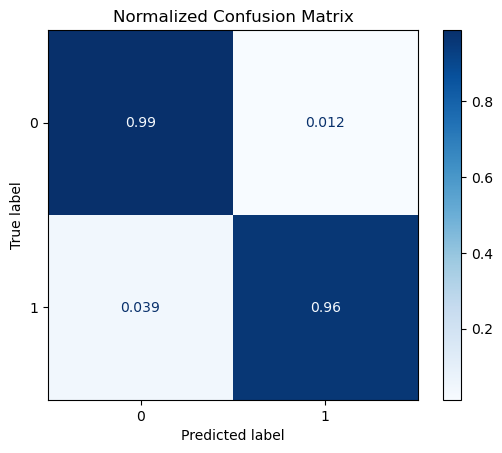

/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[13:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[13:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[14:01:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learne

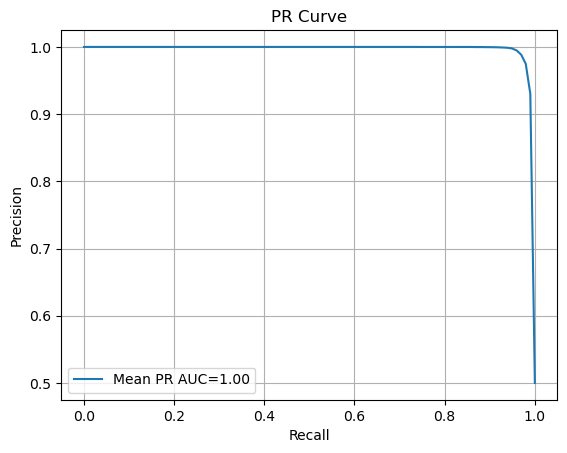

Mean PR AUC: 0.9977


/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:06:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[14:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[14:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[14:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

/opt/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[14:07:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learne

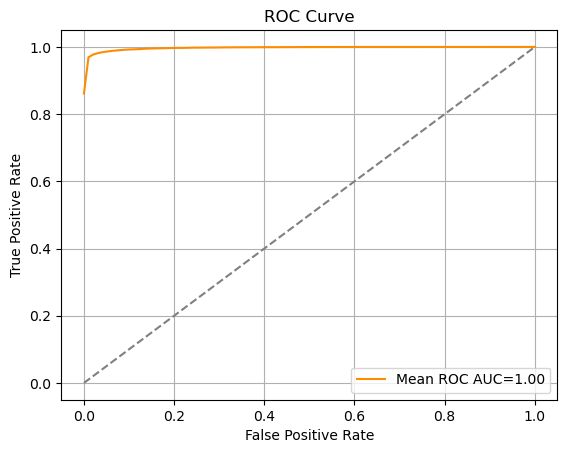

Mean ROC AUC: 0.9973


,precision,recall,f1-score,support
0,0.961709,0.987886,0.974622,20390.000000
1,0.987547,0.960667,0.973922,20390.000000
accuracy,0.974277,0.974277,0.974277,0.974277
macro avg,0.974628,0.974277,0.974272,40780.000000
weighted avg,0.974628,0.974277,0.974272,40780.000000


In [24]:
# Train/test split for evaluation
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Define Base Learners
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)

xgb_clf = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=300,
    scale_pos_weight=0.3544383149448345,
    subsample=0.7,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Define Meta Learner
meta_learner = LogisticRegression(max_iter=5000, class_weight='balanced')

# Define Stacking Model
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_clf)],
    final_estimator=meta_learner,
    passthrough=True,
    cv=3,
    n_jobs=-1
)

# Wrap training set in DataFrame
X_train_df = pd.DataFrame(X_res, columns=preprocessor.get_feature_names_out())

# Fit and Evaluate
evaluate_models(stacking_model, X_train_df.to_numpy(), y_res)


## Interpretability 

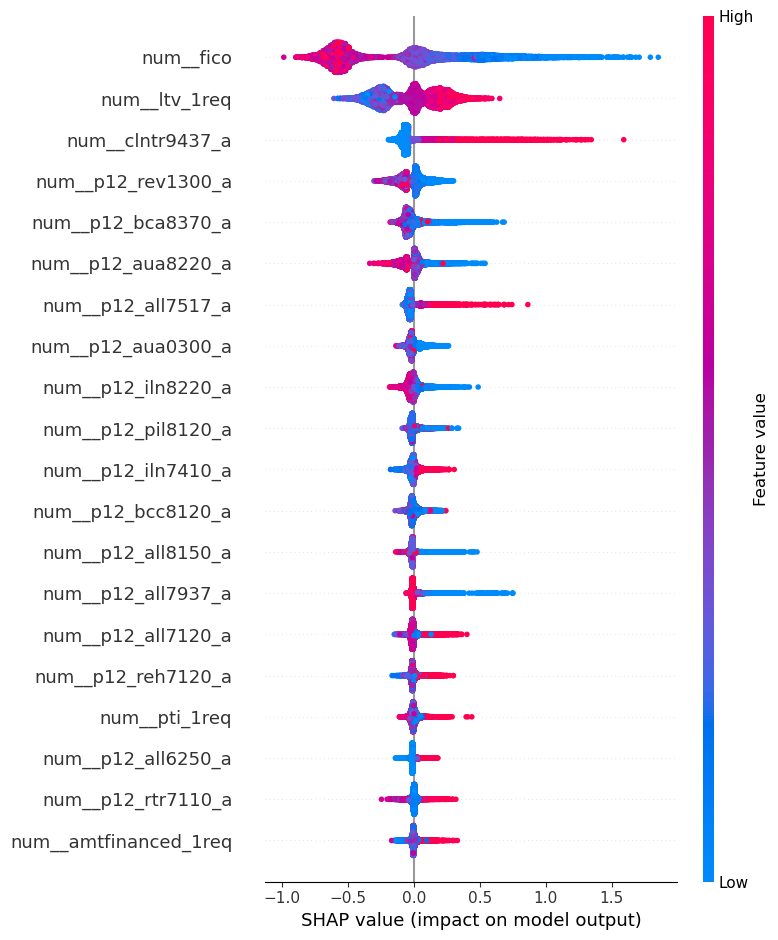

In [28]:
import shap
#access the first base learner
base_model = stacking_model.named_estimators_['xgb']

explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_train_df)

shap.summary_plot(shap_values, X_train_df)


## Fairness

In [29]:
# Fairness Metrics 
def compute_group_metrics(results, group_col):
    tpr_by_group = {}
    fpr_by_group = {}
    approval_by_group = {}

    for group in results[group_col].unique():
        group_data = results[results[group_col] == group]
        cm = confusion_matrix(group_data['true'], group_data['pred'], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        approval = group_data['pred'].mean()

        tpr_by_group[group] = round(tpr, 4)
        fpr_by_group[group] = round(fpr, 4)
        approval_by_group[group] = round(approval, 4)

    return tpr_by_group, fpr_by_group, approval_by_group

def compute_eod(metric_dict):
    vals = list(metric_dict.values())
    return round(max(vals) - min(vals), 4)

def compute_disparate_impact(approval_dict):
    rates = list(approval_dict.values())
    return round(min(rates) / max(rates), 4)


In [30]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from collections import defaultdict


df_eval_raw = pd.read_csv(eval_path)
sensitive_df = df_eval_raw[['Gender', 'Race']].reset_index(drop=True)


sensitive_df = sensitive_df.iloc[:len(y_eval_pred)].reset_index(drop=True)
y_eval = y_eval.reset_index(drop=True)

# Build prediction DataFrame
results_df = pd.DataFrame({
    'true': y_eval,
    'pred': y_eval_pred
}).reset_index(drop=True)
results_df = pd.concat([results_df, sensitive_df], axis=1)

# Filter out small or noisy groups
cleaned_results = results_df[(results_df['Race'] != 'Other') & (results_df['Gender'] != 'Undefined')].copy()

# === Gender Metrics ===
gender_metrics = compute_group_metrics(cleaned_results, 'Gender')
gender_eod = compute_eod(gender_metrics[0])
gender_di = compute_disparate_impact(gender_metrics[2])

print("\nGender Fairness (excluding 'Undefined'):")
print("TPR:", gender_metrics[0])
print("FPR:", gender_metrics[1])
print("Approval Rate:", gender_metrics[2])
print("EOD:", gender_eod)
print("DI:", gender_di)

#Race Metrics
race_metrics = compute_group_metrics(cleaned_results, 'Race')
race_eod = compute_eod(race_metrics[0])
race_di = compute_disparate_impact(race_metrics[2])

print("\nRace Fairness (excluding 'Other'):")
print("TPR:", race_metrics[0])
print("FPR:", race_metrics[1])
print("Approval Rate:", race_metrics[2])
print("EOD:", race_eod)
print("DI:", race_di)


Gender Fairness (excluding 'Undefined'):
TPR: {'Female': 0.7766, 'Male': 0.75}
FPR: {'Female': 0.2794, 'Male': 0.2824}
Approval Rate: {'Female': 0.3019, 'Male': 0.3029}
EOD: 0.0266
DI: 0.9967

Race Fairness (excluding 'Other'):
TPR: {'White': 0.75, 'Hispanic': 0.75, 'Black': 0.8276, 'Asian': 0.8}
FPR: {'White': 0.2878, 'Hispanic': 0.2634, 'Black': 0.2888, 'Asian': 0.256}
Approval Rate: {'White': 0.3079, 'Hispanic': 0.2869, 'Black': 0.3115, 'Asian': 0.2769}
EOD: 0.0776
DI: 0.8889


#### Groups such as 'Other' race and 'Undefined' gender were excluded from fairness evaluation due to small sample sizes and ambiguous categorization